#Carga de datos y preprocesamiento de datos

Carga de datos

In [1]:
import pandas as pd
from typing import cast
import seaborn as sns


dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00603/in-vehicle-coupon-recommendation.csv"

# Cargamos el dataset
dataset = pd.read_csv(dataset_url)

print("Dataset")
print(dataset.head())

# Metricas basicas del dataset
print("Numero de muestras:", dataset.shape[0])
print("Numero de atributos", dataset.shape[1])
print("Tipos de atributos", dataset.dtypes)

Dataset
       destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

   CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0        never       NaN                  4~8              1~3   
1        never       NaN                  4~8   

Análisis de dataset

Valores faltantes
destination              0.000000
passanger                0.000000
weather                  0.000000
temperature              0.000000
time                     0.000000
coupon                   0.000000
expiration               0.000000
gender                   0.000000
age                      0.000000
maritalStatus            0.000000
has_children             0.000000
education                0.000000
occupation               0.000000
income                   0.000000
car                     99.148534
Bar                      0.843582
CoffeeHouse              1.710817
CarryAway                1.190476
RestaurantLessThan20     1.024913
Restaurant20To50         1.490066
toCoupon_GEQ5min         0.000000
toCoupon_GEQ15min        0.000000
toCoupon_GEQ25min        0.000000
direction_same           0.000000
direction_opp            0.000000
Y                        0.000000
dtype: float64


<Axes: >

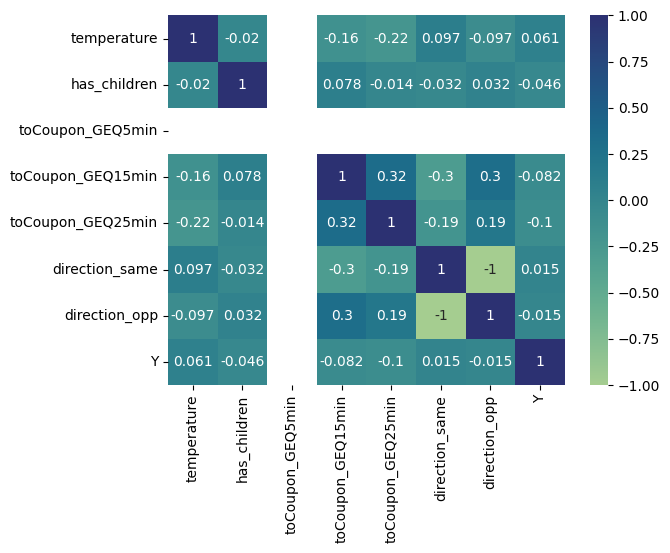

In [2]:
# Analisis del dataset

# Calculamos el porcentaje de valores faltantes
missing_values = 100 * dataset.isna().sum() / len(dataset)

print("Valores faltantes")
print(missing_values)

# Calculamos la matrix de correlacion de nuestro dataset
sns.heatmap(dataset.corr(numeric_only=True), annot=True, cmap="crest")

Preprocesamiento de datos

In [3]:
# Preprocesamiento

# Eliminamos muestras duplicadas
dataset.drop_duplicates(inplace=True)

# Eliminamos los atributos 'car', 'direction_opp' y 'toCoupon_GEQ5min'
dataset.drop(columns=["car", "direction_opp",
             "toCoupon_GEQ5min"], inplace=True)

# Completamos los valores faltantes usando la moda de cada atributo
missing_values = cast(pd.Series, dataset.isna().sum())
missing_values = cast(pd.Series, missing_values[missing_values > 0])

for column in missing_values.to_dict():
    mode = dataset[column].value_counts().index[0]
    dataset[column].fillna(mode, inplace=True)

print("Existen valores faltantes?", dataset.isna().values.any())

Existen valores faltantes? False


In [4]:
#Tabla de informacion inicial
dataset.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,$37500 - $49999,never,never,1~3,4~8,1~3,0,0,0,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,$37500 - $49999,never,never,1~3,4~8,1~3,0,0,0,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,0


### Ingenieria de atributos

In [5]:
dataset["is_unemployed"] = dataset["occupation"].map(
    lambda o: 1 if o == "Unemployed" else 0)

dataset["is_student"] = dataset["occupation"].map(
    lambda o: 1 if o == "Student" else 0)

dataset.drop(columns=["occupation"], inplace=True)

### Encodificación: One hot encoding

In [6]:
categorical_columns = dataset.dtypes[dataset.dtypes ==
                                     "object"].index.to_list()
for column in categorical_columns:
    encoded = pd.get_dummies(dataset[column], prefix=column, dtype=int)

    print("encoding", column)
    # XGBoost necesita que los atributos no contengan los caracteres '[', ']' o '<'
    if "coupon_Restaurant(<20)" in encoded.columns:
       encoded.rename(
            {"coupon_Restaurant(<20)": "coupon_Restaurant(LessThan20)"}, axis=1, inplace=True)

    dataset.drop(columns=[column], inplace=True)
    dataset = dataset.join(encoded)

# Guardamos el dataset preprocesado
#dataset.to_csv("in-vehicle-coupon-recommendation-processed.csv", index=False)

encoding destination
encoding passanger
encoding weather
encoding time
encoding coupon
encoding expiration
encoding gender
encoding age
encoding maritalStatus
encoding education
encoding income
encoding Bar
encoding CoffeeHouse
encoding CarryAway
encoding RestaurantLessThan20
encoding Restaurant20To50


In [7]:
#Tabla de informacion final
dataset.head()

,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y,is_unemployed,is_student,destination_Home,destination_No Urgent Place,...,RestaurantLessThan20_1~3,RestaurantLessThan20_4~8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_1~3,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never
0,55,1,0,0,0,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
1,80,1,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
2,80,1,1,0,0,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
3,80,1,1,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
4,80,1,1,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0


### División del Dataset

In [8]:
#Separamos la data, en variables independientes (x) y dependientes (y), para poder entrenar un árbol de clasificación
x = dataset.drop(["Y"], axis=1)

y = dataset["Y"]

In [9]:
#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. El parámetro "random state" nos sirve para
#poder replicar la misma separación
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=42)

### Entrenamiento de Modelos

Librerías necesarias


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import log_loss,roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
import xgboost as xgb

from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import numpy as np

# Creación de una función para el ploteo de la curva AUC
def plot_roc_curve(model, x_test, y_test):
  y_pred_proba = model.predict_proba(x_test)[::,1]
  fpr, tpr, th = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  model_name = type(model).__name__
  plt.title(f"{model_name}'s ROC Curve")
  plt.plot(fpr,tpr,label="auc="+str(auc))
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.legend(loc=4)
  plt.show()

## Regresion Logistica

In [11]:
# Creación del clasificador de regresión logistica
lr_model = LogisticRegression()

In [12]:
# Definición de los hiperparámetros a buscar en la búsqueda aleatoria
lr_parameters = {
    "C":[0.01, 0.1, 1, 10, 100, 500],
    "max_iter": [500, 1000]
}

In [13]:
# Búsqueda aleatoria de hiperparámetros
lr_model_search = RandomizedSearchCV(
    lr_model,
    param_distributions=lr_parameters,
    n_iter=10,  # Número de combinaciones de hiperparámetros a probar
    cv=5,  # Número de divisiones para la validación cruzada
    random_state=42,
    n_jobs=-1
)
lr_model_search.fit(x_train, y_train)

# Creacion del clasificador LogisticRegression con los mejores hiperparámetros
lr_model = LogisticRegression(**lr_model_search.best_params_)

# Entrenamiento del modelo con los datos de entrenamiento
lr_model.fit(x_train, y_train)

LogisticRegression(C=10, max_iter=1000)

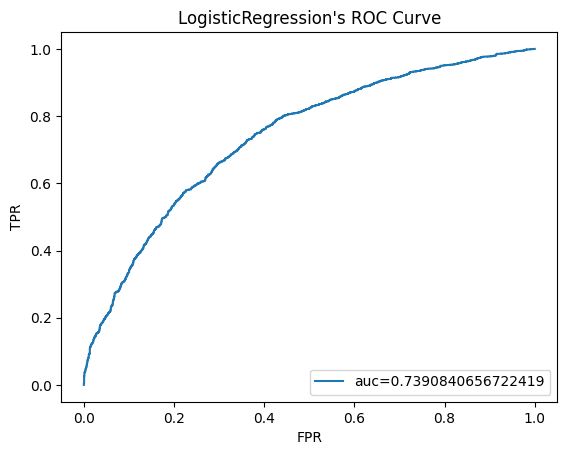

In [14]:
# Cálculo del AUC y gráfica de la Curva ROC
plot_roc_curve(lr_model, x_test, y_test)

In [15]:
# Evaluar el modelo con los datos de prueba
y_pred = lr_model.predict(x_test)

#AUNQUE SE HA DEFINIDO EL AUC COMO MÉTRICA
# se imprime un resumen de los demás indicadores
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.57      0.62      1654
           1       0.70      0.79      0.74      2129

    accuracy                           0.69      3783
   macro avg       0.69      0.68      0.68      3783
weighted avg       0.69      0.69      0.69      3783



## Random Forest

In [16]:
# Clasificador Random Forest
rf_model = RandomForestClassifier()

In [17]:
# Definición de hiperparámetros a buscar en la búsqueda aleatoria
rf_parameters = {
    "n_estimators": [500, 1000, 1500, 2000],
    "max_depth": [50, 100, 150, 200, 250, 300],
    "max_features": ["sqrt", "log2"]
}

In [18]:
# Búsqueda aleatoria de hiperparámetros
rf_model_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_parameters,
    n_iter=10,  # Número de combinaciones de hiperparámetros a probar
    cv=5,  # Número de divisiones para la validación cruzada
    random_state=42,
    n_jobs=-1
)
rf_model_search.fit(x_train, y_train)

# Clasificador LogisticRegression con los mejores hiperparámetros
rf_model = RandomForestClassifier(**rf_model_search.best_params_)

# Entrenamineto del modelo
rf_model.fit(x_train, y_train)

/home/echo/dev/in-vehicle-coupon-recommendation/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForestClassifier(max_depth=300, n_estimators=2000)

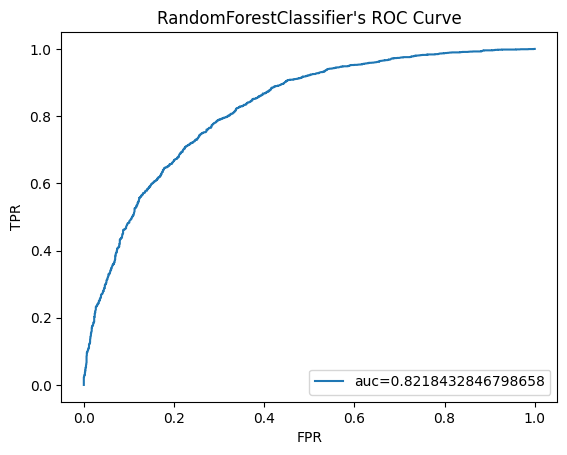

In [19]:
# Cálculo del AUC y gráfica de la Curva ROC
plot_roc_curve(rf_model, x_test, y_test)

In [20]:
# Evaluar el modelo con los datos de prueba
y_pred = rf_model.predict(x_test)

#AUNQUE SE HA DEFINIDO EL AUC COMO MÉTRICA
# se imprime un resumen de los demás indicadores
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.65      0.69      1654
           1       0.75      0.83      0.79      2129

    accuracy                           0.75      3783
   macro avg       0.75      0.74      0.74      3783
weighted avg       0.75      0.75      0.75      3783



## SVM

In [21]:
# clasificador SVC
svm_model = SVC()

In [22]:
# Definición de hiperparámetros a buscar en la búsqueda aleatoria
svm_parameters = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"]
}

In [23]:
# Búsqueda aleatoria de hiperparámetros
svm_model_search = RandomizedSearchCV(
    svm_model,
    param_distributions=svm_parameters,
    n_iter=10,  # Número de combinaciones de hiperparámetros a probar
    cv=5,  # Número de divisiones para la validación cruzada
    random_state=42,
    n_jobs=-1
)
svm_model_search.fit(x_train, y_train)

# Clasificador LogisticRegression con los mejores hiperparámetros
svm_model = SVC(**svm_model_search.best_params_, probability=True)

# Entrenamineto del modelo
svm_model.fit(x_train, y_train)

SVC(C=10, gamma='auto', probability=True)

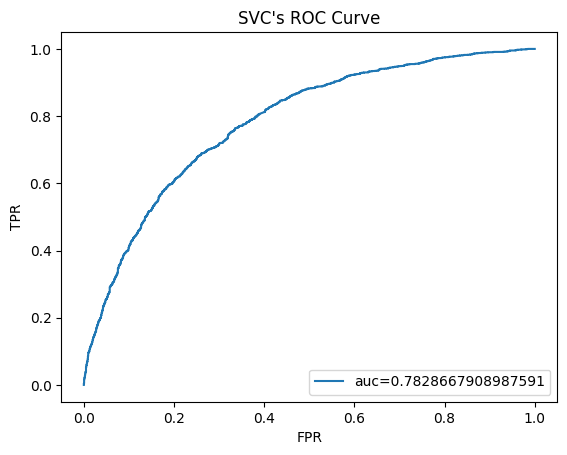

In [24]:
# Cálculo del AUC y gráfica de la Curva ROC
plot_roc_curve(svm_model, x_test, y_test)

In [25]:
# Evaluar el modelo con los datos de prueba
y_pred = svm_model.predict(x_test)

#AUNQUE SE HA DEFINIDO EL AUC COMO MÉTRICA
# se imprime un resumen de los demás indicadores
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.60      0.65      1654
           1       0.72      0.81      0.77      2129

    accuracy                           0.72      3783
   macro avg       0.72      0.71      0.71      3783
weighted avg       0.72      0.72      0.72      3783



## XGBoost

In [26]:
# Crear el clasificador XGBoost
xgb_model = xgb.XGBClassifier()

In [27]:
# Definir los hiperparámetros a buscar en la búsqueda aleatoria
xgb_parameters = {
    "max_depth": [1, 5, 10, 50],
    "n_estimators": [100, 500, 1000, 2000]
}

In [28]:
# Realizar la búsqueda aleatoria de hiperparámetros
xgb_model_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_parameters,
    n_iter=10,  # Número de combinaciones de hiperparámetros a probar
    cv=5,  # Número de divisiones para la validación cruzada
    random_state=42,
    n_jobs=-1
)
xgb_model_search.fit(x_train, y_train)

# Clasificador LogisticRegression con los mejores hiperparámetros
xgb_model = xgb.XGBClassifier(**xgb_model_search.best_params_)

# Entrenamiento del modelo
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

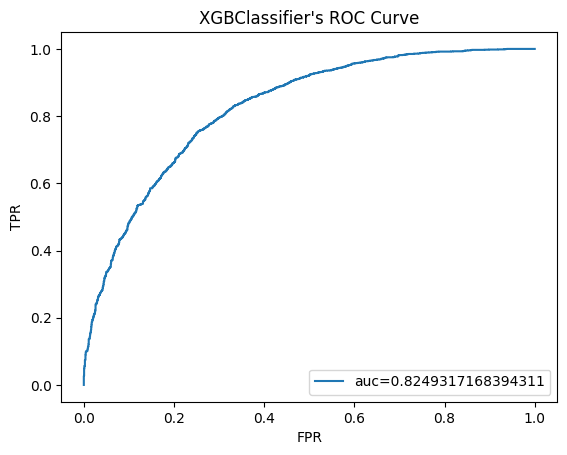

In [29]:
# Cálculo del AUC y gráfica de la Curva ROC
plot_roc_curve(xgb_model, x_test, y_test)

In [30]:
# Evaluar el modelo con los datos de prueba
y_pred = xgb_model.predict(x_test)

#AUNQUE SE HA DEFINIDO EL AUC COMO MÉTRICA
# se imprime un resumen de los demás indicadores
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1654
           1       0.77      0.81      0.79      2129

    accuracy                           0.75      3783
   macro avg       0.75      0.75      0.75      3783
weighted avg       0.75      0.75      0.75      3783



## Multi Layer Perceptron

In [31]:
# Clasificador de redes neuronales
mlp_model = MLPClassifier()

In [32]:
# Definición de hiperparámetros a buscar en la búsqueda aleatoria
mlp_parameters = {
    "hidden_layer_sizes": [[100], [200], [300], [500]],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "max_iter": [700, 700]
}

In [33]:
# Búsqueda aleatoria de hiperparámetros
mlp_model_search = RandomizedSearchCV(
    mlp_model,
    param_distributions=mlp_parameters,
    n_iter=10,  # Número de combinaciones de hiperparámetros a probar
    cv=5,  # Número de divisiones para la validación cruzada
    random_state=42,
    n_jobs=-1
)
mlp_model_search.fit(x_train, y_train)

# Clasificador LogisticRegression con los mejores hiperparámetros
mlp_model = MLPClassifier(**mlp_model_search.best_params_)

# Entrenamineto del modelo
mlp_model.fit(x_train, y_train)

/home/echo/dev/in-vehicle-coupon-recommendation/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/echo/dev/in-vehicle-coupon-recommendation/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/echo/dev/in-vehicle-coupon-recommendation/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/echo/dev/in-vehicle-coupon-recommendation/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maxim

MLPClassifier(activation='logistic', hidden_layer_sizes=[300], max_iter=700)

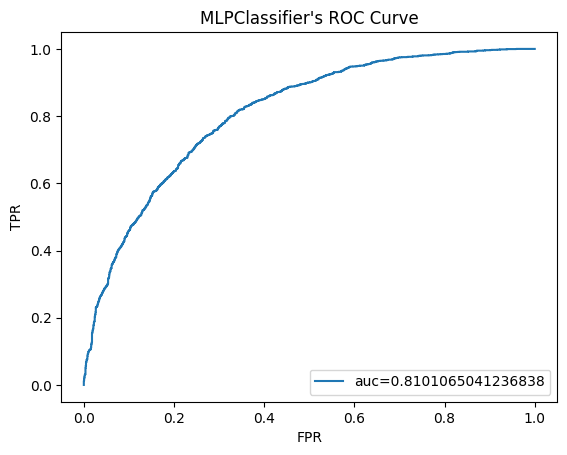

In [34]:
# Cálculo del AUC y gráfica de la Curva ROC
plot_roc_curve(mlp_model, x_test, y_test)

In [35]:
# Evaluar el modelo con los datos de prueba
y_pred = mlp_model.predict(x_test)


#AUNQUE SE HA DEFINIDO EL AUC COMO MÉTRICA
# se imprime un resumen de los demás indicadores
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1654
           1       0.76      0.78      0.77      2129

    accuracy                           0.74      3783
   macro avg       0.74      0.73      0.74      3783
weighted avg       0.74      0.74      0.74      3783



## Stacking

In [36]:
# Utilizamos nuestros clasificadores optimizados
estimators = [
    ("RandomForest", rf_model),
    ("XGBoost", xgb_model),
    ("MLP", mlp_model)
]

# Creamos el modelo ensamble y realizamos el entrenamiento
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(penalty="l2"))

stacking_model.fit(x_train, y_train)

/home/echo/dev/in-vehicle-coupon-recommendation/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/echo/dev/in-vehicle-coupon-recommendation/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/echo/dev/in-vehicle-coupon-recommendation/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/echo/dev/in-vehicle-coupon-recommendation/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maxim

StackingClassifier(estimators=[('RandomForest',
                                RandomForestClassifier(max_depth=300,
                                                       n_estimators=2000)),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=50,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=500, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('MLP',
                                MLPClassifier(activation='logistic',
                                              hidden_layer_sizes=[300],
                                              max_iter=700))],
                   final_estimator=LogisticRegression())

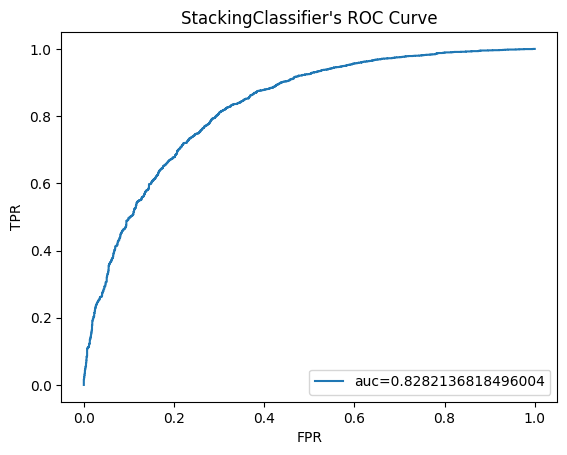

In [37]:
# Cálculo del AUC y gráfica de la Curva ROC
plot_roc_curve(stacking_model, x_test, y_test)

In [38]:
# Evaluar el modelo con los datos de prueba
y_pred = stacking_model.predict(x_test)

# Imprimir informe de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72      1654
           1       0.77      0.82      0.79      2129

    accuracy                           0.76      3783
   macro avg       0.76      0.75      0.75      3783
weighted avg       0.76      0.76      0.76      3783



Comparativa AUC

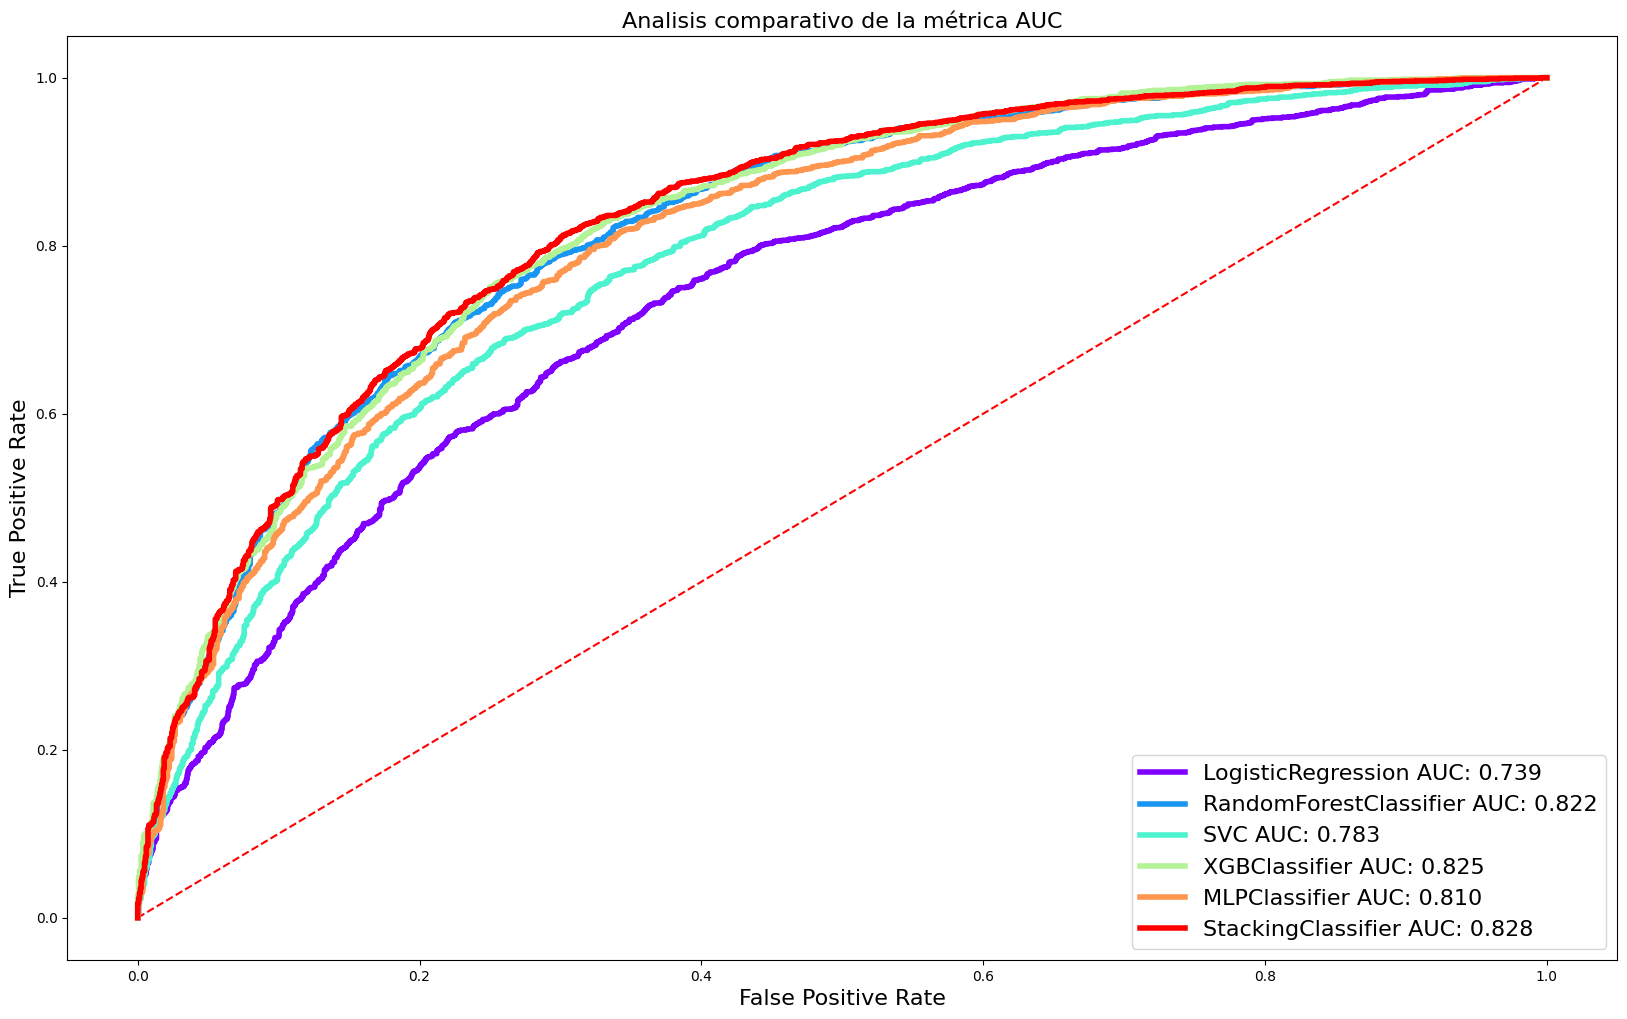

In [41]:
from sklearn.metrics import roc_curve, auc
from matplotlib.cm import rainbow

models = [
  lr_model,
  rf_model,
  svm_model,
  xgb_model,
  mlp_model,
  stacking_model
]

colors = rainbow(np.linspace(0, 1, len(models)))

plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

for (idx, model) in enumerate(models):
  model_name = type(model).__name__
  y_pred_proba = model.predict_proba(x_test)[::, 1]
  fpr, tpr, th = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)

  label = model_name + " AUC:" + " {0:.3f}".format(auc)
  plt.plot(fpr, tpr, c = colors[idx], label = label, linewidth = 4)

plt.xlabel("False Positive Rate", fontsize = 16)
plt.ylabel("True Positive Rate", fontsize = 16)
plt.title("Analisis comparativo de la métrica AUC", fontsize = 16)
plt.legend(loc = "lower right", fontsize = 16)